In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.utils import resample, shuffle
import sys
import pandas as pd
import shap

name = "wild"
with open("features/features_" + name + ".csv", "r") as f:
  line = f.readline()
  feature_names = line.split(",")
  feature_names.pop(0)
  feature_names.pop(0)

data = pd.read_csv("features/features_" + name + ".csv")
labels = pd.read_csv("labels/labels_" + name + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')

names = data.loc[:,"name"]
y = data.loc[:,"label"]
X = data.drop(["name","label","write_execute_size"], axis = 1)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [34]:
name2 = "new"
data = pd.read_csv("features/features_" + name2 + ".csv")
labels = pd.read_csv("labels/labels_" + name2 + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')
y_test_wild = data.loc[:,"label"]
X_test_wild = data.drop(["name","label","write_execute_size"], axis = 1)

packed = pd.read_csv("features/features_packed.csv")
notpacked = pd.read_csv("features/features_notpacked.csv")
packed1 = pd.read_csv("features/static_features_packed.csv")
notpacked1 = pd.read_csv("features/static_features_notpacked.csv")
packed = packed.merge(packed1[["name"]], on='name')
notpacked = notpacked.merge(notpacked1[["name"]], on='name')
X_clean = pd.concat([packed,notpacked], ignore_index = True)
X_clean = X_clean.drop(["name","write_execute_size"], axis = 1)
y_clean = np.append(np.ones(len(packed)),np.zeros(len(notpacked)))
X_clean, y_clean = shuffle(X_clean, y_clean, random_state=0)

In [35]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12]}
dt = DecisionTreeClassifier(random_state=0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=dt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model1 = search.best_estimator_
y_pred = model1.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2} with a score of 0.86349 in training and a score of 0.91507 in testing
The F1-score is 0.95000
The balance accuracy is 0.86583
The precision is 0.96722
The recall is 0.93338
              precision    recall  f1-score   support

       False       0.65      0.80      0.72       233
        True       0.97      0.93      0.95      1486

    accuracy                           0.92      1719
   macro avg       0.81      0.87      0.83      1719
weighted avg       0.92      0.92      0.92      1719



In [36]:
y_pred_wild = model1.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))

y_pred_clean = model1.predict(X_clean)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_clean,y_pred_clean))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_clean,y_pred_clean))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_clean,y_pred_clean))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_clean,y_pred_clean))
)
print(classification_report(y_clean,y_pred_clean))

The F1-score is 0.58462
The balance accuracy is 0.40038
The precision is 0.47699
The recall is 0.75497
              precision    recall  f1-score   support

       False       0.14      0.05      0.07       131
        True       0.48      0.75      0.58       151

    accuracy                           0.43       282
   macro avg       0.31      0.40      0.33       282
weighted avg       0.32      0.43      0.35       282

The F1-score is 0.84880
The balance accuracy is 0.57477
The precision is 0.87161
The recall is 0.82716
              precision    recall  f1-score   support

         0.0       0.25      0.32      0.28       335
         1.0       0.87      0.83      0.85      1863

    accuracy                           0.75      2198
   macro avg       0.56      0.57      0.57      2198
weighted avg       0.78      0.75      0.76      2198



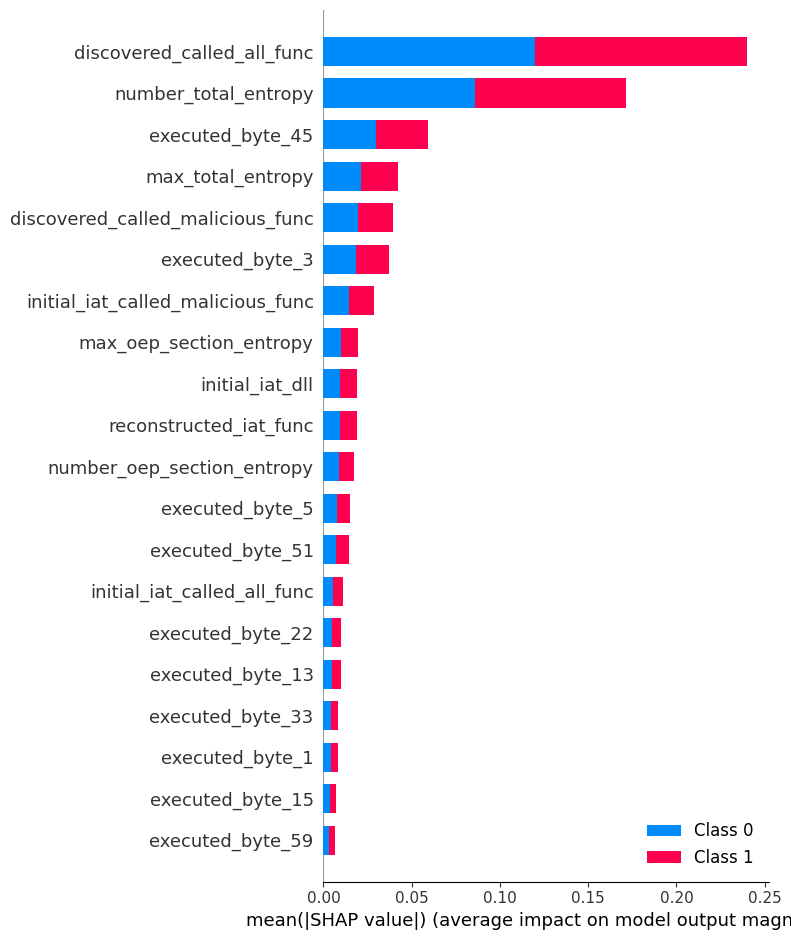

In [37]:
explainer = shap.Explainer(model1)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/"+name+"_fig1.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [38]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
rf = RandomForestClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=rf, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model2 = search.best_estimator_
y_pred = model2.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 39} with a score of 0.87755 in training and a score of 0.95404 in testing
The F1-score is 0.97357
The balance accuracy is 0.88657
The precision is 0.96806
The recall is 0.97914
              precision    recall  f1-score   support

       False       0.86      0.79      0.82       233
        True       0.97      0.98      0.97      1486

    accuracy                           0.95      1719
   macro avg       0.91      0.89      0.90      1719
weighted avg       0.95      0.95      0.95      1719



In [39]:
y_pred_wild = model2.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))

y_pred_clean = model2.predict(X_clean)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_clean,y_pred_clean))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_clean,y_pred_clean))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_clean,y_pred_clean))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_clean,y_pred_clean))
)
print(classification_report(y_clean,y_pred_clean))

The F1-score is 0.64891
The balance accuracy is 0.45516
The precision is 0.51145
The recall is 0.88742
              precision    recall  f1-score   support

       False       0.15      0.02      0.04       131
        True       0.51      0.89      0.65       151

    accuracy                           0.49       282
   macro avg       0.33      0.46      0.34       282
weighted avg       0.34      0.49      0.37       282

The F1-score is 0.93053
The balance accuracy is 0.58630
The precision is 0.87050
The recall is 0.99946
              precision    recall  f1-score   support

         0.0       0.98      0.17      0.29       335
         1.0       0.87      1.00      0.93      1863

    accuracy                           0.87      2198
   macro avg       0.93      0.59      0.61      2198
weighted avg       0.89      0.87      0.83      2198



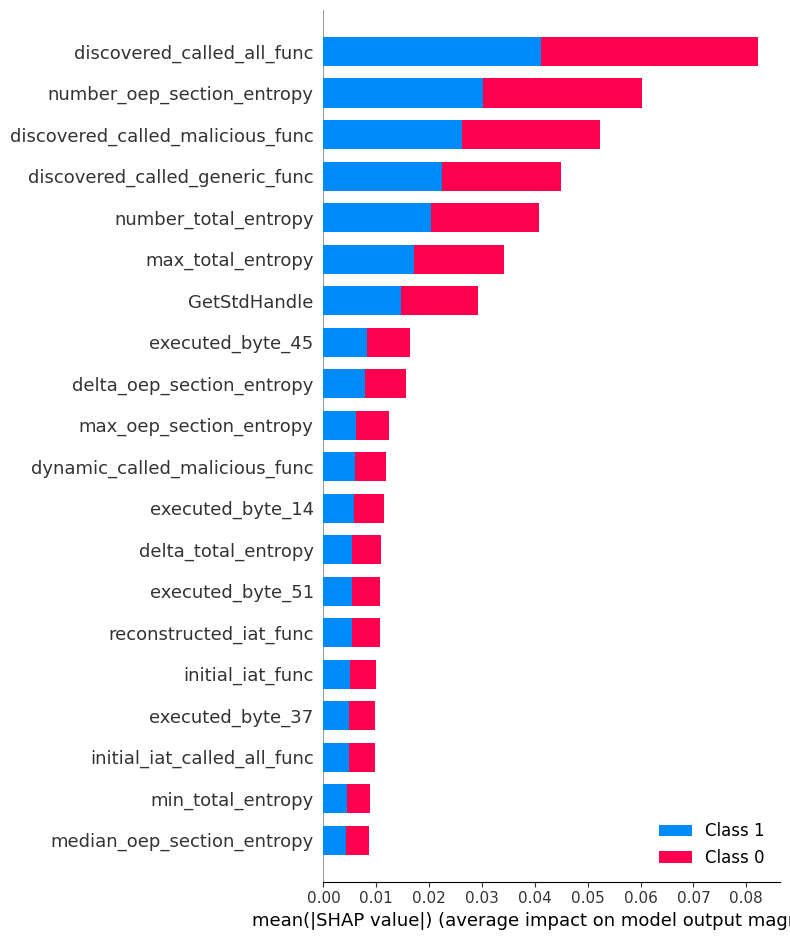

In [40]:
explainer = shap.Explainer(model2)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/"+name+"_fig2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
param_grid = {"criterion":["friedman_mse","squared_error"],"loss": ["log_loss","exponential"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
gbdt = GradientBoostingClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=gbdt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model3 = search.best_estimator_
y_pred = model3.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

In [ ]:
explainer = shap.Explainer(model3)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/"+name+"_fig3.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [41]:
with open("features/static_features_" + name + ".csv", "r") as f:
  line = f.readline()
  feature_names = line.split(",")
  feature_names.pop(0)

data = pd.read_csv("features/features_" + name + ".csv")
labels = pd.read_csv("labels/labels_" + name + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')
data_static = pd.read_csv("features/static_features_" + name + ".csv")
data_static = data_static.merge(data[["name","label"]], on='name')
y = data_static.loc[:,"label"]
X = data_static.drop(["name", "label"], axis = 1)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [42]:
data = pd.read_csv("features/features_" + name2 + ".csv")
labels = pd.read_csv("labels/labels_" + name2 + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')
data_static = pd.read_csv("features/static_features_" + name2 + ".csv")
data_static = data_static.merge(data[["name","label"]], on='name')
y_test_wild = data_static.loc[:,"label"]
X_test_wild = data_static.drop(["name", "label"], axis = 1)

packed1 = pd.read_csv("features/features_packed.csv")
notpacked1 = pd.read_csv("features/features_notpacked.csv")
packed = pd.read_csv("features/static_features_packed.csv")
notpacked = pd.read_csv("features/static_features_notpacked.csv")
packed = packed.merge(packed1[["name"]], on='name')
notpacked = notpacked.merge(notpacked1[["name"]], on='name')
X_clean = pd.concat([packed,notpacked], ignore_index = True)
X_clean = X_clean.drop(["name"], axis = 1)
y_clean = np.append(np.ones(len(packed)),np.zeros(len(notpacked)))
X_clean, y_clean = shuffle(X_clean, y_clean, random_state=0)

In [43]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12]}
dt = DecisionTreeClassifier(random_state=0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=dt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model4 = search.best_estimator_
y_pred = model4.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 2} with a score of 0.82573 in training and a score of 0.89878 in testing
The F1-score is 0.94049
The balance accuracy is 0.82746
The precision is 0.95619
The recall is 0.92530
              precision    recall  f1-score   support

       False       0.60      0.73      0.66       233
        True       0.96      0.93      0.94      1486

    accuracy                           0.90      1719
   macro avg       0.78      0.83      0.80      1719
weighted avg       0.91      0.90      0.90      1719



In [44]:
y_pred_wild = model4.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))

y_pred_clean = model4.predict(X_clean)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_clean,y_pred_clean))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_clean,y_pred_clean))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_clean,y_pred_clean))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_clean,y_pred_clean))
)
print(classification_report(y_clean,y_pred_clean))

The F1-score is 0.78571
The balance accuracy is 0.79172
The precision is 0.85271
The recall is 0.72848
              precision    recall  f1-score   support

       False       0.73      0.85      0.79       131
        True       0.85      0.73      0.79       151

    accuracy                           0.79       282
   macro avg       0.79      0.79      0.79       282
weighted avg       0.80      0.79      0.79       282

The F1-score is 0.92038
The balance accuracy is 0.63307
The precision is 0.88503
The recall is 0.95867
              precision    recall  f1-score   support

         0.0       0.57      0.31      0.40       335
         1.0       0.89      0.96      0.92      1863

    accuracy                           0.86      2198
   macro avg       0.73      0.63      0.66      2198
weighted avg       0.84      0.86      0.84      2198



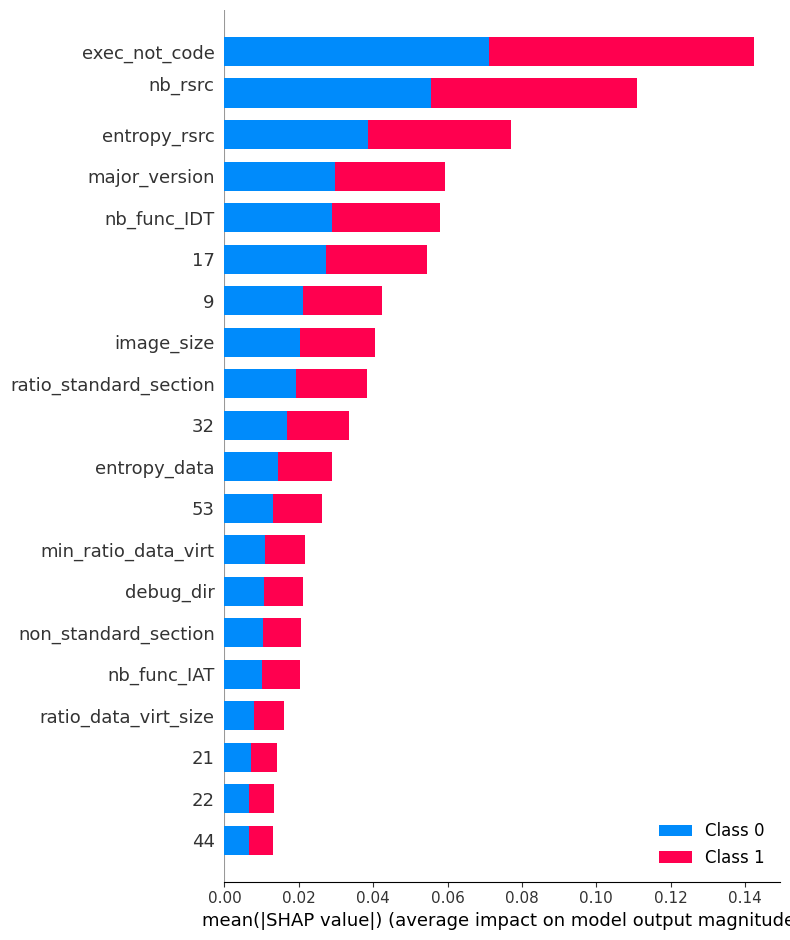

In [45]:
explainer = shap.Explainer(model4)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/"+name+"_fig4.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [46]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
rf = RandomForestClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=rf, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model5 = search.best_estimator_
y_pred = model5.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 3, 'n_estimators': 10} with a score of 0.78256 in training and a score of 0.91972 in testing
The F1-score is 0.95458
The balance accuracy is 0.76900
The precision is 0.93428
The recall is 0.97577
              precision    recall  f1-score   support

       False       0.78      0.56      0.65       233
        True       0.93      0.98      0.95      1486

    accuracy                           0.92      1719
   macro avg       0.86      0.77      0.80      1719
weighted avg       0.91      0.92      0.91      1719



In [47]:
y_pred_wild = model5.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))

y_pred_clean = model5.predict(X_clean)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_clean,y_pred_clean))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_clean,y_pred_clean))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_clean,y_pred_clean))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_clean,y_pred_clean))
)
print(classification_report(y_clean,y_pred_clean))

The F1-score is 0.68224
The balance accuracy is 0.48344
The precision is 0.52708
The recall is 0.96689
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       131
        True       0.53      0.97      0.68       151

    accuracy                           0.52       282
   macro avg       0.26      0.48      0.34       282
weighted avg       0.28      0.52      0.37       282

The F1-score is 0.93360
The balance accuracy is 0.60448
The precision is 0.87547
The recall is 1.00000
              precision    recall  f1-score   support

         0.0       1.00      0.21      0.35       335
         1.0       0.88      1.00      0.93      1863

    accuracy                           0.88      2198
   macro avg       0.94      0.60      0.64      2198
weighted avg       0.89      0.88      0.84      2198



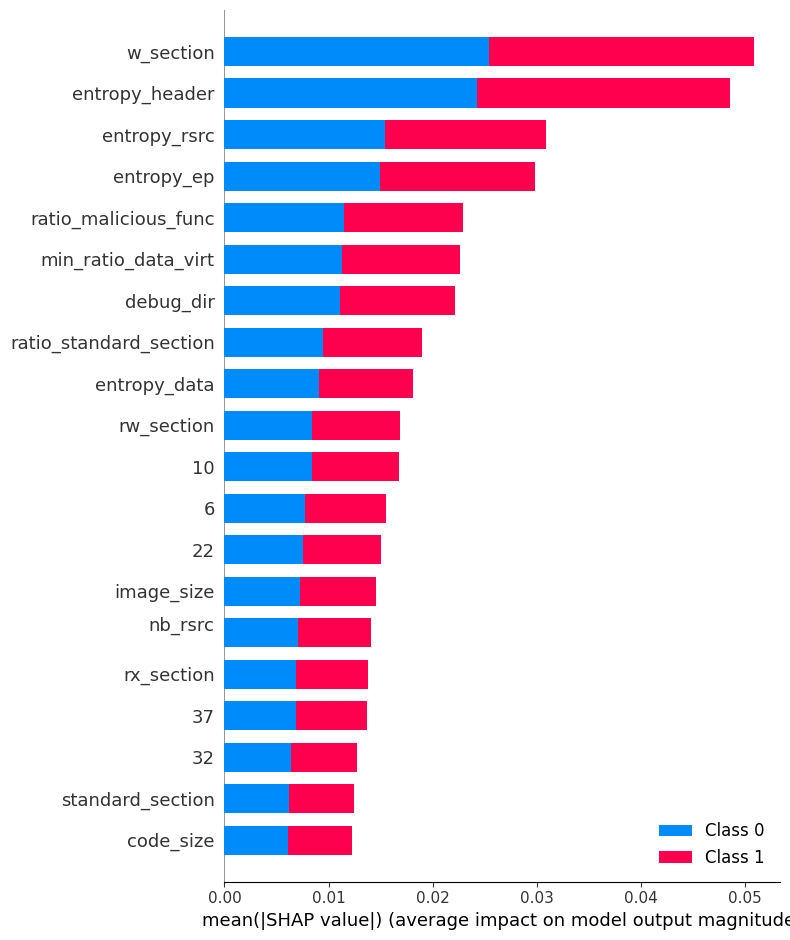

In [48]:
explainer = shap.Explainer(model5)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/"+name+"_fig5.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
param_grid = {"criterion":["friedman_mse","squared_error"],"loss": ["log_loss","exponential"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
gbdt = GradientBoostingClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=gbdt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model6 = search.best_estimator_
y_pred = model6.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

In [ ]:
explainer = shap.Explainer(model6)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/"+name+"_fig6.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [49]:
with open("features/static_features_" + name + ".csv", "r") as f:
  line = f.readline()
  static_feature_names = line.split(",")
  static_feature_names.pop(0)

with open("features/features_" + name + ".csv", "r") as f:
  line = f.readline()
  feature_names = line.split(",")
  feature_names.pop(0)

feature_names = feature_names.append(static_feature_names)

data = pd.read_csv("features/features_" + name + ".csv")
data_static = pd.read_csv("features/static_features_" + name + ".csv")
data = data.merge(data_static, on='name')

labels = pd.read_csv("labels/labels_" + name + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')

names = data.loc[:,"name"]
y = data.loc[:,"label"]
X = data.drop(["name","label","write_execute_size"], axis = 1)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [50]:
data = pd.read_csv("features/features_" + name2 + ".csv")
data_static = pd.read_csv("features/static_features_" + name2 + ".csv")
data = data.merge(data_static, on='name')

labels = pd.read_csv("labels/labels_" + name2 + ".csv",header=None, names=['name', 'label'])
data = data.merge(labels, on='name')

names = data.loc[:,"name"]
y_test_wild = data.loc[:,"label"]
X_test_wild = data.drop(["name","label","write_execute_size"], axis = 1)

packed = pd.read_csv("features/features_packed.csv")
notpacked = pd.read_csv("features/features_notpacked.csv")
packed1 = pd.read_csv("features/static_features_packed.csv")
notpacked1 = pd.read_csv("features/static_features_notpacked.csv")
packed = packed.merge(packed1, on='name')
notpacked = notpacked.merge(notpacked1, on='name')
X_clean = pd.concat([packed,notpacked], ignore_index = True)
X_clean = X_clean.drop(["name","write_execute_size"], axis = 1)
y_clean = np.append(np.ones(len(packed)),np.zeros(len(notpacked)))
X_clean, y_clean = shuffle(X_clean, y_clean, random_state=0)

In [51]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12]}
dt = DecisionTreeClassifier(random_state=0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=dt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model7 = search.best_estimator_
y_pred = model7.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4} with a score of 0.87759 in training and a score of 0.92496 in testing
The F1-score is 0.95640
The balance accuracy is 0.85165
The precision is 0.96062
The recall is 0.95222
              precision    recall  f1-score   support

       False       0.71      0.75      0.73       233
        True       0.96      0.95      0.96      1486

    accuracy                           0.92      1719
   macro avg       0.84      0.85      0.84      1719
weighted avg       0.93      0.92      0.93      1719



In [52]:
y_pred_wild = model7.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))

y_pred_clean = model7.predict(X_clean)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_clean,y_pred_clean))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_clean,y_pred_clean))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_clean,y_pred_clean))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_clean,y_pred_clean))
)
print(classification_report(y_clean,y_pred_clean))

The F1-score is 0.71720
The balance accuracy is 0.64393
The precision is 0.64062
The recall is 0.81457
              precision    recall  f1-score   support

       False       0.69      0.47      0.56       131
        True       0.64      0.81      0.72       151

    accuracy                           0.66       282
   macro avg       0.66      0.64      0.64       282
weighted avg       0.66      0.66      0.64       282

The F1-score is 0.89331
The balance accuracy is 0.54762
The precision is 0.86106
The recall is 0.92807
              precision    recall  f1-score   support

         0.0       0.29      0.17      0.21       335
         1.0       0.86      0.93      0.89      1863

    accuracy                           0.81      2198
   macro avg       0.58      0.55      0.55      2198
weighted avg       0.77      0.81      0.79      2198



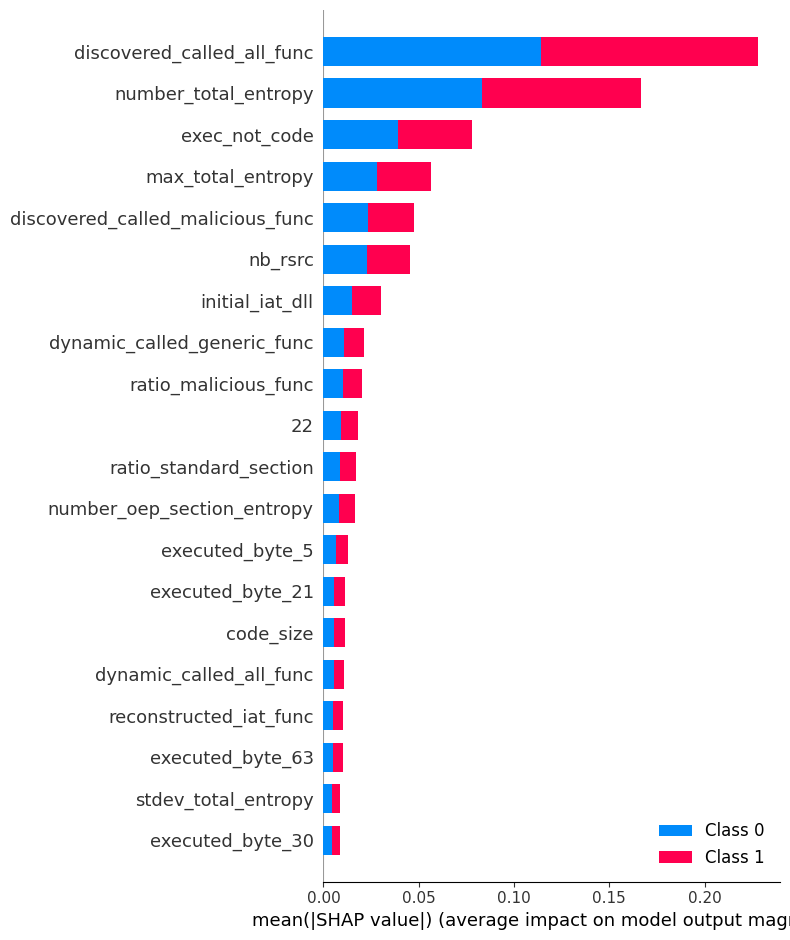

In [53]:
explainer = shap.Explainer(model7)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/"+name+"_fig7.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [54]:
param_grid =  {"criterion": ["gini","entropy"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
rf = RandomForestClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=rf, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model8 = search.best_estimator_
y_pred = model8.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

The best parameters are {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 2, 'n_estimators': 39} with a score of 0.88893 in training and a score of 0.96219 in testing
The F1-score is 0.97818
The balance accuracy is 0.91299
The precision is 0.97589
The recall is 0.98048
              precision    recall  f1-score   support

       False       0.87      0.85      0.86       233
        True       0.98      0.98      0.98      1486

    accuracy                           0.96      1719
   macro avg       0.92      0.91      0.92      1719
weighted avg       0.96      0.96      0.96      1719



In [55]:
y_pred_wild = model8.predict(X_test_wild)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test_wild,y_pred_wild))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test_wild,y_pred_wild))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test_wild,y_pred_wild))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test_wild,y_pred_wild))
)
print(classification_report(y_test_wild,y_pred_wild))

y_pred_clean = model8.predict(X_clean)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_clean,y_pred_clean))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_clean,y_pred_clean))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_clean,y_pred_clean))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_clean,y_pred_clean))
)
print(classification_report(y_clean,y_pred_clean))

The F1-score is 0.66024
The balance accuracy is 0.46891
The precision is 0.51894
The recall is 0.90728
              precision    recall  f1-score   support

       False       0.22      0.03      0.05       131
        True       0.52      0.91      0.66       151

    accuracy                           0.50       282
   macro avg       0.37      0.47      0.36       282
weighted avg       0.38      0.50      0.38       282

The F1-score is 0.93360
The balance accuracy is 0.60448
The precision is 0.87547
The recall is 1.00000
              precision    recall  f1-score   support

         0.0       1.00      0.21      0.35       335
         1.0       0.88      1.00      0.93      1863

    accuracy                           0.88      2198
   macro avg       0.94      0.60      0.64      2198
weighted avg       0.89      0.88      0.84      2198



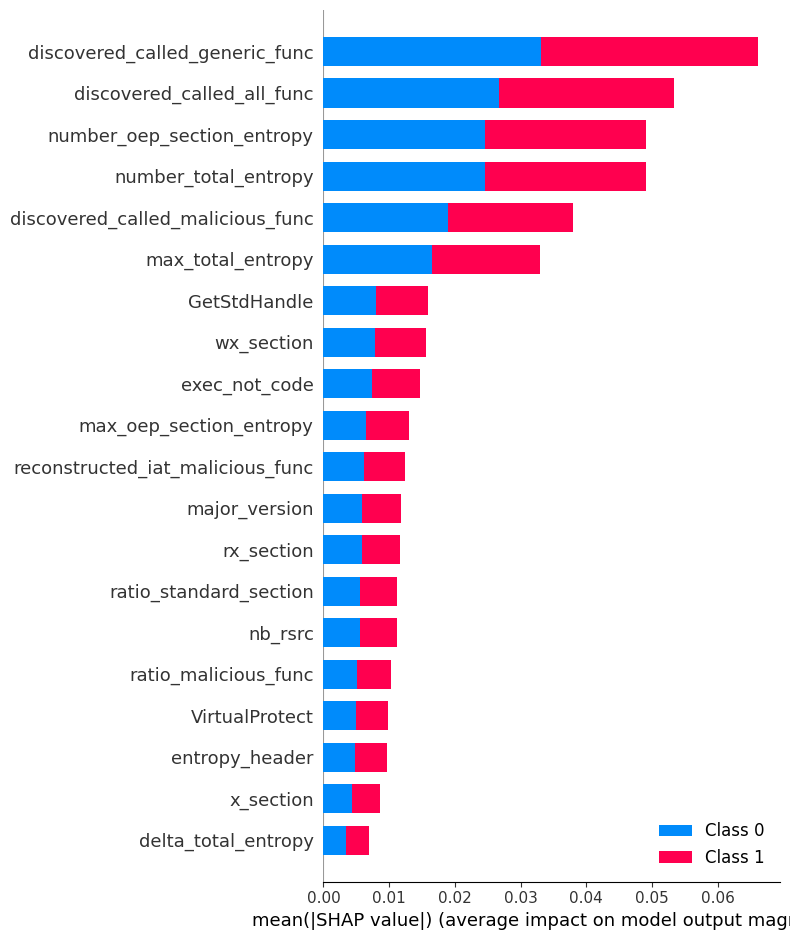

In [56]:
explainer = shap.Explainer(model8)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/"+name+"_fig8.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
param_grid = {"criterion":["friedman_mse","squared_error"],"loss": ["log_loss","exponential"],"min_samples_leaf":[2,3,4,5,6,7,8,9,10,11,12],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12],"n_estimators" : [i for i in range(10,40)]}
gbdt = GradientBoostingClassifier(random_state = 0)
cv = StratifiedKFold(n_splits=10)
search = GridSearchCV(estimator=gbdt, param_grid=param_grid, cv = cv, scoring = "balanced_accuracy", n_jobs = -1)
search.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.5f in training and a score of %0.5f in testing"
    % (search.best_params_, search.best_score_,search.best_estimator_.score(X_test,y_test))
)
model9 = search.best_estimator_
y_pred = model9.predict(X_test)
print(
    "The F1-score is %0.5f"
    % (f1_score(y_test,y_pred))
)
print(
    "The balance accuracy is %0.5f"
    % (balanced_accuracy_score(y_test,y_pred))
)
print(
    "The precision is %0.5f"
    % (precision_score(y_test,y_pred))
)
print(
    "The recall is %0.5f"
    % (recall_score(y_test,y_pred))
)
print(classification_report(y_test,y_pred))

In [ ]:
explainer = shap.Explainer(model9)
shap_obj = explainer(X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features = X_train,feature_names=feature_names,show=False)
plt.savefig("figures/"+name+"_fig9.pdf", format="pdf", bbox_inches="tight")
plt.show()